Handling missing data

Text(0, 0.5, 'Passengers')

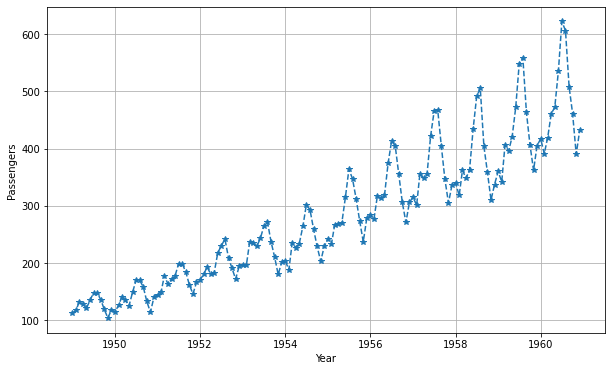

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df["Month"] = pd.to_datetime(df["Month"])   #convert column to datetime
df.set_index("Month", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
#check for missing values
df.isnull().values.any()

False

In [ ]:
#missing values, we will make a copy of our dataset and delete some values at random
df_copy = df.copy()
rows = df_copy.sample(frac=0.1, random_state=0)
rows['Passengers']= np.nan
df_copy.loc[rows.index, 'Passengers'] = rows['Passengers']
df_copy.isnull().sum()

Passengers    14
dtype: int64

In [ ]:
#filling missing data by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method='ffill')
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

In [ ]:
#filling missing data by imputation - Backward fill
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

In [ ]:
#filling missing data by interpolation
df_copy_LIF = df_copy.interpolate(method='linear',limit_direction='forward')
df_copy_LIF.isnull().sum()
df_copy_LIB = df_copy.interpolate(method='linear', limit_direction='backward')
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

In [ ]:
#moving average smoothing
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(12).mean()

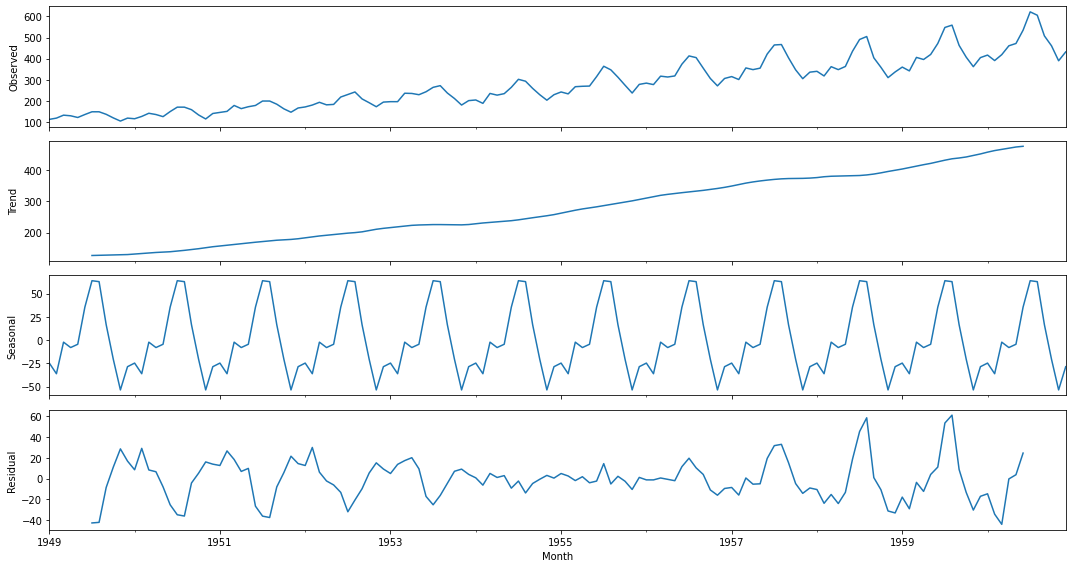

In [ ]:
#Time series specific exploratory methods
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
decompose_series = sm.tsa.seasonal_decompose(df['Passengers'], model='additive')
decompose_series.plot()
plt.show()

In [ ]:
#The decomposed time series show an obvious increasing trend and seasinality variation.
#Recall that we have initially plotted the moving average on the last 12 months which showed that it varies with time. 
#This suggests that the data is not stationary.
# We will now perform an ADF test to confirm this speculation

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
  print(f' {k}: {v}')


ADF Statistic: 0.8153688792060418
p-value: 0.9918802434376409
No. of lags used: 13
No. of observations used: 130
Critical Values:
 1%: -3.4816817173418295
 5%: -2.8840418343195267
 10%: -2.578770059171598


In [ ]:
#From the results obtained, the p-value is greater than the critical value at a 5% #significance level and, the ADF statistic is greater that any of the critical values obtain. 
#This confirms that the series is indeed non-stationary.
#Convert time series to stationary by removing trend and seasonality
#Transformation and Differencing

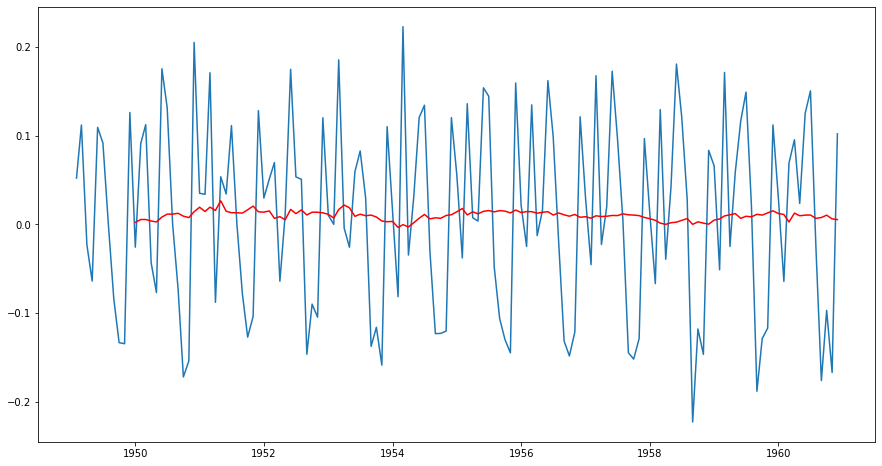

In [ ]:
df_log = np.log(df)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index,df_diff.Passengers,'-')
plt.plot(df_diff.rolling(12).mean(), color='red')

In [ ]:
#unsampling
df_quaterly = df.resample('3M').mean()

#unsample to daily data points
df_daily = df.resample('D').mean()

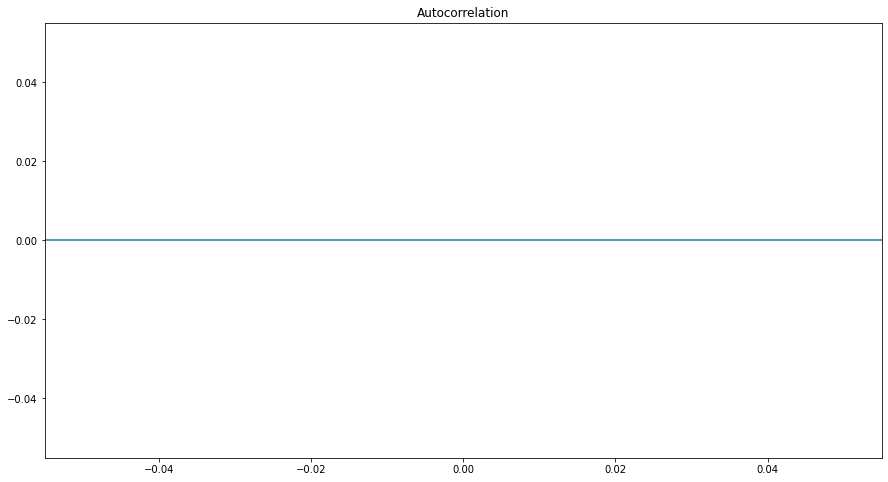

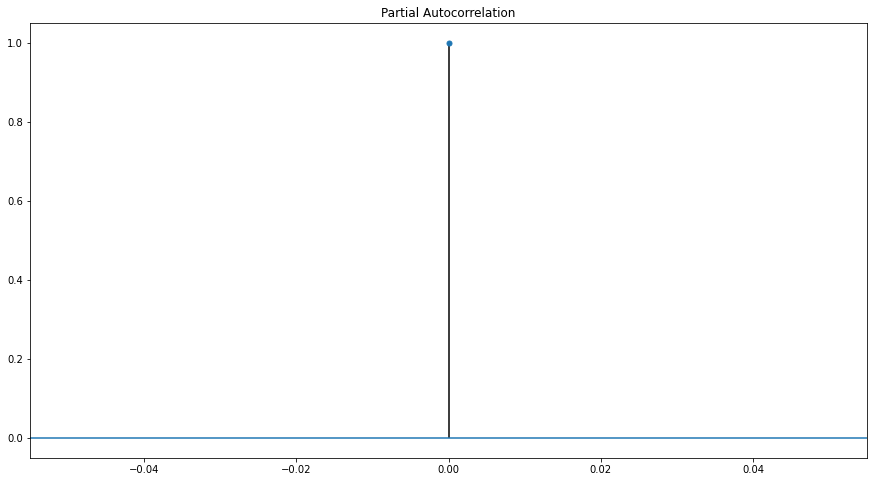

In [ ]:
#Time series forecasting using stochastic models

from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#ACF
plot_acf(df_diff,lags= range(0,20) )
plt.show()

#PACF
plot_pacf(df_diff, lags = range(0,20))
plt.show()

In [ ]:
#The shaded regions in the plots are the confidence intervals.
# The lags where the PACF and #ACF charts cross this region are the values for p and q respectively. 
#In the ACF plot, there is one lag that crosses the significance level hence, q=1.
# Similarly #in the PACF plot, p=2


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



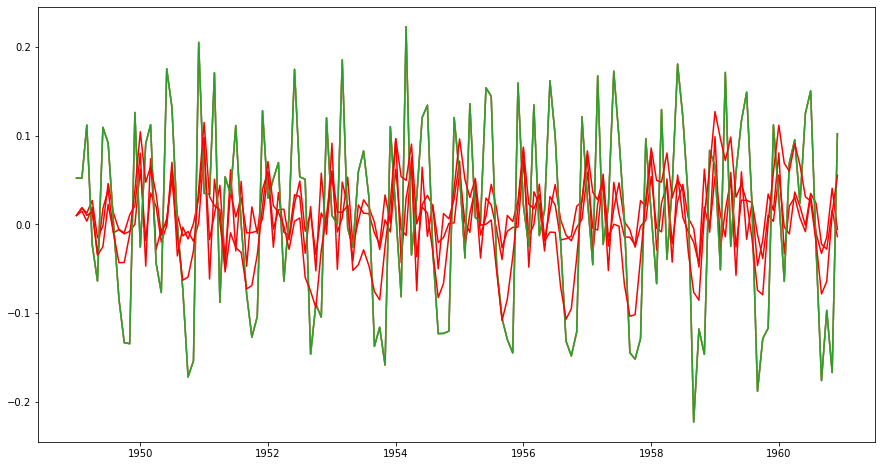

In [ ]:
df_diff = df_diff.fillna(method='bfill')

#AR, MA and ARIMA
from statsmodels.tsa.arima_model import ARIMA

#(p,d,q)
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color='red')

MA_model = ARIMA(df_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color='red')

ARIMA_model = ARIMA(df_diff, order=(2,0,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color='red')


In [ ]:
# Time Series at Scale

from fbprophet import Prophet
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.rename(columns={"Month": "ds", "Passengers":"y"})
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#predict for the next 10 months
future = model.make_future_dataframe(periods=10, freq='M')
forecast = model.predict(future)
forecast.head()
forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]

#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries



,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,1949-01-01,84.807353,56.609798,114.183529,106.727984,106.727984,106.727984
1,1949-02-01,78.218354,50.796984,107.365977,108.901201,108.901201,108.901201
2,1949-03-01,110.361397,84.530232,139.565929,110.864107,110.864107,110.864107
3,1949-04-01,107.851823,80.531192,136.251958,113.037323,113.037323,113.037323
4,1949-05-01,111.351735,82.669581,140.484245,115.140437,115.140437,115.140437
...,...,...,...,...,...,...,...
149,1961-05-31,533.992919,506.452790,562.424102,502.558318,502.364636,502.716534
150,1961-06-30,577.062353,548.766626,608.850227,505.571811,505.326324,505.773708
151,1961-07-31,575.495626,545.676270,602.683970,508.685754,508.382565,508.944829
152,1961-08-31,529.069236,500.625919,559.177087,511.799697,511.442562,512.111284


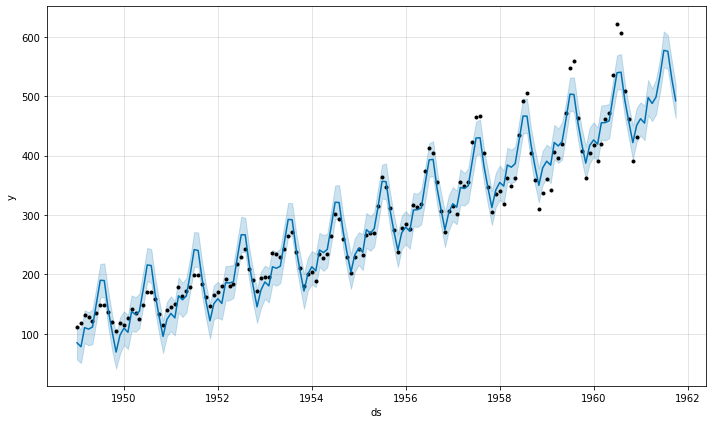

In [ ]:
model.plot(forecast)
plt.show()

QUIZ: Individual Household Electric Power Consumption

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df1=pd.read_csv("/content/household_power_consumption.csv", sep=";", parse_dates={'dt': ['Date', 'Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='dt' )

In [ ]:

df1.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df1.isnull().values.any()

True

In [ ]:
df1.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
df1.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
df1.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

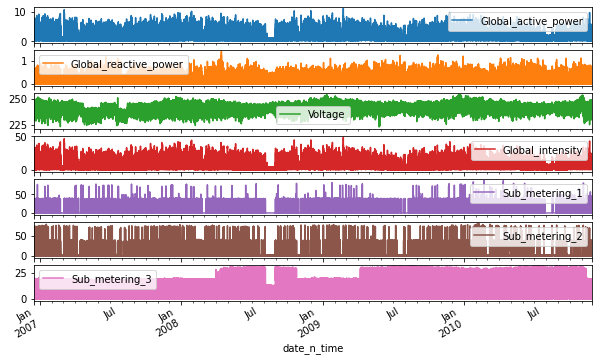

In [ ]:
# Visualization data before imputation
df1.plot(subplots=True, figsize=(10,6))
plt.show()

In [ ]:
#imputation
for a in range (0,7):
  df1.iloc[:,a]=df1.iloc[:,a].fillna(df1.iloc[:,a].mean())


In [ ]:
df1.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
#energy not measured by sub meterings 1,2,3
values = df1.values.astype('float32')
df1['sub_metering_4'] = (values[:,0]*1000/60)-(values[:,4] + values [:,5] + values[:,6])
df1.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.099998


In [ ]:
df1.to_csv('new_household_power_consumption.csv')

In [ ]:
df2 = pd.read_csv("new_household_power_consumption.csv",header = 0, infer_datetime_format=True,parse_dates=['dt'] ,index_col=['dt' ])

In [ ]:
df2.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


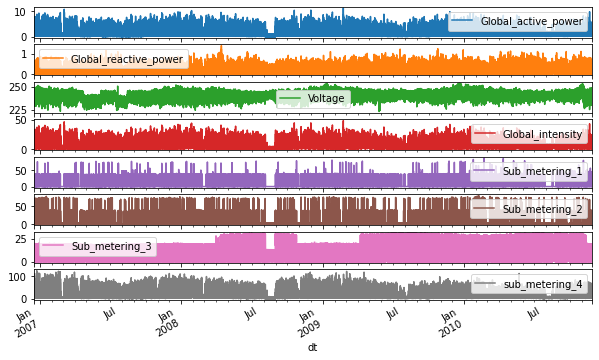

In [ ]:
# Visualization data after imputation
df2.plot(subplots=True, figsize=(10,6))
plt.show()

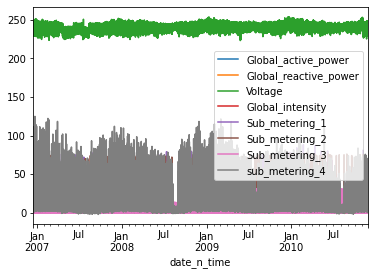

In [ ]:
df2.plot()

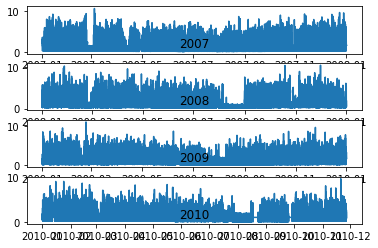

In [ ]:
years = ['2007', '2008', '2009', '2010']
plt.figure()
for i in range(len(years)):
    # getting the subplot
    ax = plt.subplot(len(years), 1, i+1)
    # getting the year to plot
    year = years[i]
    # finding all observations for the year
    result = df2[str(year)]
    # plotting the active power for the year
    plt.plot(result['Global_active_power'])
    # add a title to the subplot
    plt.title(str(year), y=0, loc='center')
plt.show()

                     Global_active_power  ...  sub_metering_4
date_n_time                               ...                
2006-12-16 17:24:00                4.216  ...       52.266670
2006-12-16 17:25:00                5.360  ...       72.333336
2006-12-16 17:26:00                5.374  ...       70.566666
2006-12-16 17:27:00                5.388  ...       71.800000
2006-12-16 17:28:00                3.666  ...       43.100000

[5 rows x 8 columns]


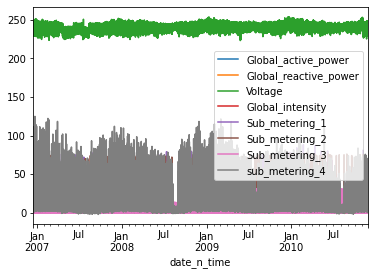

In [ ]:
# Average consumption of each month in 4 years
df2.groupby(df2.index.month).Global_active_power.mean()
print(df2.head())
df2.plot()

In [ ]:
df2.corr()

,Global_active_power,y,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555,0.701380
y,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617,0.211624
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172,-0.271371
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543,0.703258
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571,0.125067
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872,0.085201
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000,0.178724
sub_metering_4,0.701380,0.211624,-0.271371,0.703258,0.125067,0.085201,0.178724,1.000000


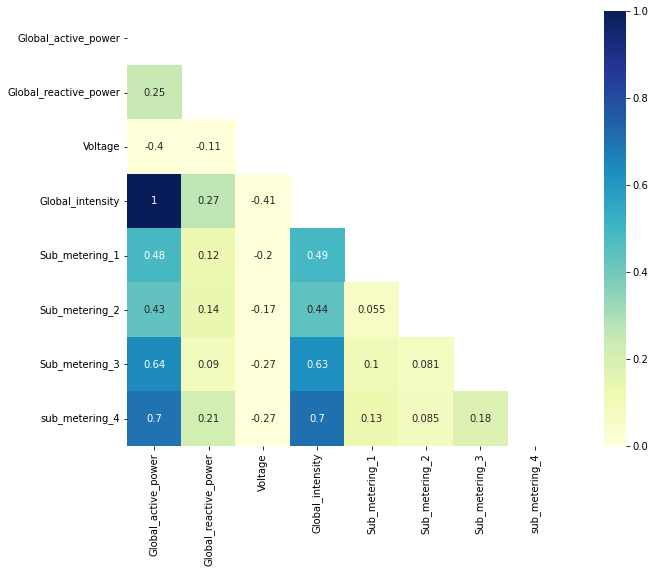

In [ ]:
import seaborn as sns
pearson = df2.corr(method='pearson')
mask = np.zeros_like(pearson)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pearson, vmax=1, vmin=0, square=True, cbar=True, annot=True, cmap="YlGnBu", mask=mask);

In [ ]:


X = df2.iloc[:,[1,3,4,5,6]]
y = df2.iloc[:,0]

X.head()



,y,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,
2006-12-16 17:24:00,0.418,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,0.436,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,0.498,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,0.502,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,0.528,15.8,0.0,1.0,17.0


In [ ]:
y.head()

date_n_time
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [-0.17588232  0.2366809  -0.0002924  -0.00041025  0.00216129]


Text(0, 0.5, 'Predicted Y')

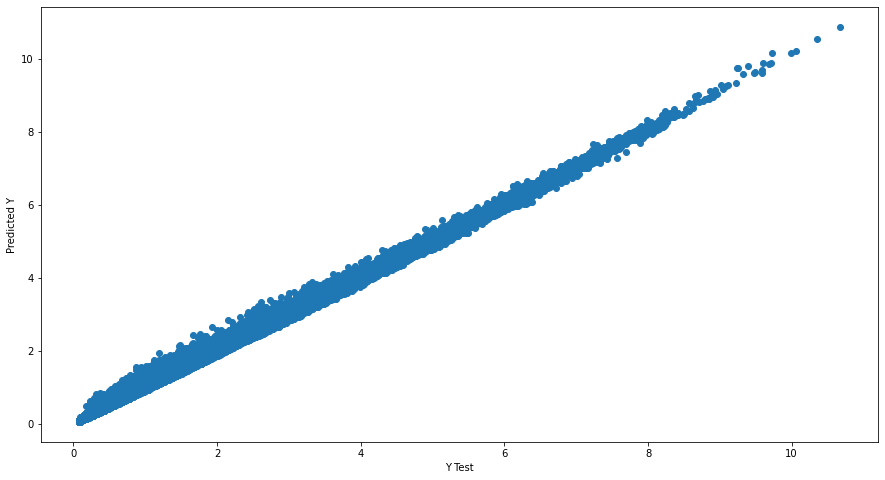

In [ ]:
predictions = lm.predict( X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print ('R Squares value:',metrics.r2_score(y_test, predictions))

MAE: 0.027160039716212205
MSE: 0.0018030625343306561
RMSE: 0.042462483845515396
R Squares value: 0.9983631589542357


In [ ]:
from sklearn.linear_model import Lasso
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(X_train,y_train)

Lasso(alpha=0.00099, copy_X=True, fit_intercept=True, max_iter=50000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso_pred = lm.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test,lasso_pred))
print('MSE:', metrics.mean_squared_error(y_test,lasso_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,lasso_pred)))
print ('R Squares value:',metrics.r2_score(y_test,lasso_pred))

MAE: 0.027160039716212205
MSE: 0.0018030625343306561
RMSE: 0.042462483845515396
R Squares value: 0.9983631589542357


In [ ]:
# Time Series at Scale

from fbprophet import Prophet

# df['Month'] = pd.to_datetime(df['Month'])
# df2 = df2[['dt','y']]
# df2.columns = ['dt','y']
# df2.head()

prophet = pd.DataFrame(df1['Global_active_power'])
prophet.index = pd.to_datetime(prophet.index)

In [ ]:
prophet.head()

,Global_active_power
dt,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [ ]:
train = prophet.copy().loc["2007-01":"2007-03"]
test = prophet.copy().loc["2007-04":"2007-04"]

train.reset_index(inplace=True)
test.reset_index(inplace=True)

train.columns = ['dt','y']
test.columns = ['dt','y']

print("Train Shape: {}, Test Shape: {}".format(train.shape, test.shape))

Train Shape: (129600, 2), Test Shape: (43200, 2)


In [ ]:
model = Prophet(weekly_seasonality=False,
                yearly_seasonality=False,
                daily_seasonality=False).add_seasonality(name='weekly',
                                                         period=7,
                                                         fourier_order=15).add_seasonality(name='daily',period=1,
                                                                                           fourier_order=20).add_seasonality(name='monthly',
                                                                                                                             period=30.5,
                                                                                                                             fourier_order=15)
                                                                                           


In [ ]:
model.fit(train)

In [ ]:
testForecast = test.copy().drop('y', axis=1)
testForecast.head()

,dt
0,2007-04-01 00:00:00
1,2007-04-01 00:01:00
2,2007-04-01 00:02:00
3,2007-04-01 00:03:00
4,2007-04-01 00:04:00
